In [1]:
import os
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam

In [3]:
class Config:
    csv_path = ''
    seed = 2021
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    
config = Config()
seed_everything(config.seed)
config.device

'cuda:0'

In [4]:
!nvidia-smi

Thu Nov  6 15:16:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 30%   27C    P8             11W /  300W |     982MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import pickle

path_db = "./ECG_DATASET/dataset_ekg.pkl"

with open(path_db, 'rb') as f:
    data = pickle.load(f)

data

{'NSR': array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
          0.13048524,  0.11548524],
        [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
          0.33548524,  0.31548524],
        [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
         -0.20451476, -0.20451476],
        ...,
        [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
         -0.58951476, -0.58951476],
        [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
         -0.44451476, -0.40451476],
        [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
          0.20048524,  0.18548524]], shape=(283, 3600)),
 'VT': array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
         -0.00212931,  0.01787069],
        [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
          0.84787069,  0.86787069],
        [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
          0.06787069,  0.10287069],
        ...,
        [ 0.17287069, 

In [6]:
data.items()

dict_items([('NSR', array([[-0.06451476, -0.05951476, -0.02951476, ...,  0.13548524,
         0.13048524,  0.11548524],
       [ 0.24548524,  0.25048524,  0.24048524, ...,  0.34048524,
         0.33548524,  0.31548524],
       [ 0.13048524,  0.12548524,  0.11048524, ..., -0.20451476,
        -0.20451476, -0.20451476],
       ...,
       [-0.46451476, -0.46451476, -0.46451476, ..., -0.59451476,
        -0.58951476, -0.58951476],
       [-0.53451476, -0.51451476, -0.53451476, ..., -0.51451476,
        -0.44451476, -0.40451476],
       [ 0.51548524,  0.50548524,  0.50548524, ...,  0.21048524,
         0.20048524,  0.18548524]], shape=(283, 3600))), ('VT', array([[ 0.10787069,  0.08787069,  0.08787069, ...,  0.01287069,
        -0.00212931,  0.01787069],
       [-0.31212931, -0.29712931, -0.27212931, ...,  0.82787069,
         0.84787069,  0.86787069],
       [ 0.01287069,  0.00787069,  0.00287069, ...,  0.04787069,
         0.06787069,  0.10287069],
       ...,
       [ 0.17287069,  0.167

In [33]:
# Convertir data en DataFrame con keys como clases
df_list = []

for clase, signals in data.items():
    # Crear un DataFrame temporal con las señales de esta clase
    df_temp = pd.DataFrame(signals)
    # Agregar columna con el nombre de la clase
    df_temp['label'] = clase
    df_list.append(df_temp)

# Concatenar todos los DataFrames
df = pd.concat(df_list, axis=0, ignore_index=True)

# Mostrar información del DataFrame
print(f"Shape: {df.shape}")
print(f"Clases únicas: {df['label'].unique()}")
print(f"Distribución por clase:\n{df['label'].value_counts()}")
df.head()

Shape: (1000, 3601)
Clases únicas: ['NSR' 'VT' 'IVR' 'VFL' 'Fusion' 'LBBBB' 'RBBBB' 'SDHB' 'PR' 'APB' 'AFL'
 'AFIB' 'SVTA' 'WPW' 'PVC' 'Bigeminy' 'Trigeminy']
Distribución por clase:
label
NSR          283
AFIB         135
PVC          133
LBBBB        103
APB           66
RBBBB         62
Bigeminy      55
PR            45
WPW           21
AFL           20
SVTA          13
Trigeminy     13
Fusion        11
SDHB          10
VT            10
IVR           10
VFL           10
Name: count, dtype: int64


0         1         2         3         4         5         6  \
0 -0.064515 -0.059515 -0.029515 -0.019515 -0.014515 -0.014515 -0.019515   
1  0.245485  0.250485  0.240485  0.230485  0.240485  0.240485  0.250485   
2  0.130485  0.125485  0.110485  0.100485  0.105485  0.115485  0.120485   
3 -0.499515 -0.409515 -0.394515 -0.419515 -0.469515 -0.504515 -0.559515   
4  0.245485  0.265485  0.255485  0.250485  0.230485  0.235485  0.245485   

          7         8         9  ...      3591      3592      3593      3594  \
0 -0.009515  0.020485  0.030485  ...  0.125485  0.130485  0.120485  0.110485   
1  0.235485  0.215485  0.220485  ...  0.390485  0.375485  0.375485  0.385485   
2  0.095485  0.090485  0.085485  ... -0.139515 -0.144515 -0.164515 -0.159515   
3 -0.589515 -0.614515 -0.639515  ... -0.694515 -0.709515 -0.699515 -0.689515   
4  0.280485  0.270485  0.275485  ...  0.115485  0.110485  0.120485  0.130485   

       3595      3596      3597      3598      3599  label  
0  0.110485  0.120485  0.135485  0.130485  0.115485    NSR  
1  0.370485  0.355485  0.340485  0.335485  0.315485    NSR  
2 -0.169515 -0.189515 -0.204515 -0.204515 -0.204515    NSR  
3 -0.669515 -0.684515 -0.694515 -0.694515 -0.674515    NSR  
4  0.140485  0.135485  0.120485  0.110485  0.120485    NSR  

[5 rows x 3601 columns]

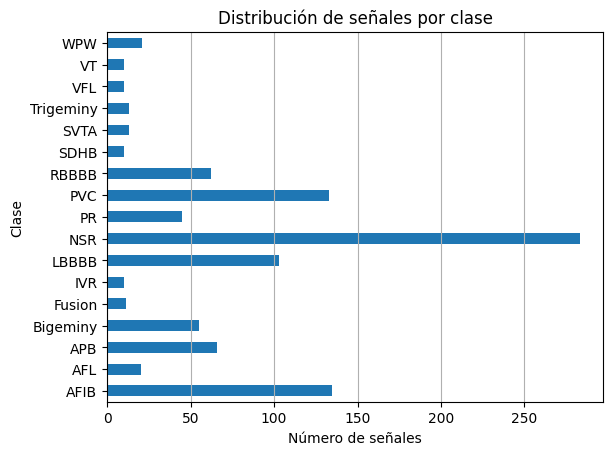

In [34]:
df.groupby('label').size().plot(kind='barh')
plt.xlabel('Número de señales')
plt.ylabel('Clase')
plt.title('Distribución de señales por clase')
plt.grid(axis='x')
plt.show()



In [65]:
df_normal = df[df["label"]=="NSR"]
df_normal.head()

0         1         2         3         4         5         6  \
0 -0.064515 -0.059515 -0.029515 -0.019515 -0.014515 -0.014515 -0.019515   
1  0.245485  0.250485  0.240485  0.230485  0.240485  0.240485  0.250485   
2  0.130485  0.125485  0.110485  0.100485  0.105485  0.115485  0.120485   
3 -0.499515 -0.409515 -0.394515 -0.419515 -0.469515 -0.504515 -0.559515   
4  0.245485  0.265485  0.255485  0.250485  0.230485  0.235485  0.245485   

          7         8         9  ...      3592      3593      3594      3595  \
0 -0.009515  0.020485  0.030485  ...  0.130485  0.120485  0.110485  0.110485   
1  0.235485  0.215485  0.220485  ...  0.375485  0.375485  0.385485  0.370485   
2  0.095485  0.090485  0.085485  ... -0.144515 -0.164515 -0.159515 -0.169515   
3 -0.589515 -0.614515 -0.639515  ... -0.709515 -0.699515 -0.689515 -0.669515   
4  0.280485  0.270485  0.275485  ...  0.110485  0.120485  0.130485  0.140485   

       3596      3597      3598      3599  label  class  
0  0.120485  0.135485  0.130485  0.115485    NSR      0  
1  0.355485  0.340485  0.335485  0.315485    NSR      0  
2 -0.189515 -0.204515 -0.204515 -0.204515    NSR      0  
3 -0.684515 -0.694515 -0.694515 -0.674515    NSR      0  
4  0.135485  0.120485  0.110485  0.120485    NSR      0  

[5 rows x 3602 columns]

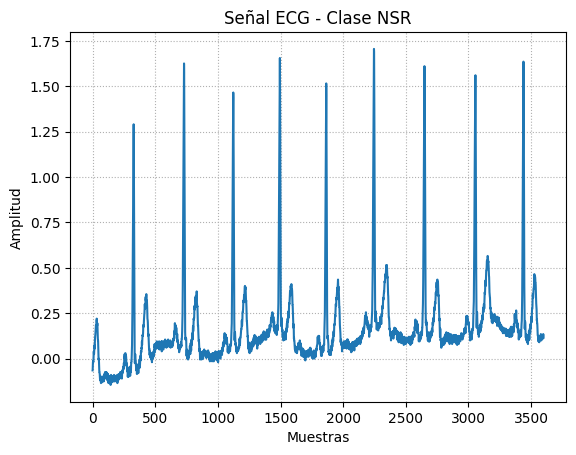

In [ ]:
df_normal.iloc[0,:-1].plot()
plt.title('Señal ECG - Clase NSR')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(ls=":")
plt.show()

In [38]:
df.label.unique()

array(['NSR', 'VT', 'IVR', 'VFL', 'Fusion', 'LBBBB', 'RBBBB', 'SDHB',
       'PR', 'APB', 'AFL', 'AFIB', 'SVTA', 'WPW', 'PVC', 'Bigeminy',
       'Trigeminy'], dtype=object)

In [39]:
label2num = {label: idx for idx, label in enumerate(df['label'].unique())}
label2num

{'NSR': 0,
 'VT': 1,
 'IVR': 2,
 'VFL': 3,
 'Fusion': 4,
 'LBBBB': 5,
 'RBBBB': 6,
 'SDHB': 7,
 'PR': 8,
 'APB': 9,
 'AFL': 10,
 'AFIB': 11,
 'SVTA': 12,
 'WPW': 13,
 'PVC': 14,
 'Bigeminy': 15,
 'Trigeminy': 16}

In [40]:
df["class"] = df['label'].map(label2num)
df.head()

0         1         2         3         4         5         6  \
0 -0.064515 -0.059515 -0.029515 -0.019515 -0.014515 -0.014515 -0.019515   
1  0.245485  0.250485  0.240485  0.230485  0.240485  0.240485  0.250485   
2  0.130485  0.125485  0.110485  0.100485  0.105485  0.115485  0.120485   
3 -0.499515 -0.409515 -0.394515 -0.419515 -0.469515 -0.504515 -0.559515   
4  0.245485  0.265485  0.255485  0.250485  0.230485  0.235485  0.245485   

          7         8         9  ...      3592      3593      3594      3595  \
0 -0.009515  0.020485  0.030485  ...  0.130485  0.120485  0.110485  0.110485   
1  0.235485  0.215485  0.220485  ...  0.375485  0.375485  0.385485  0.370485   
2  0.095485  0.090485  0.085485  ... -0.144515 -0.164515 -0.159515 -0.169515   
3 -0.589515 -0.614515 -0.639515  ... -0.709515 -0.699515 -0.689515 -0.669515   
4  0.280485  0.270485  0.275485  ...  0.110485  0.120485  0.130485  0.140485   

       3596      3597      3598      3599  label  class  
0  0.120485  0.135485  0.130485  0.115485    NSR      0  
1  0.355485  0.340485  0.335485  0.315485    NSR      0  
2 -0.189515 -0.204515 -0.204515 -0.204515    NSR      0  
3 -0.684515 -0.694515 -0.694515 -0.674515    NSR      0  
4  0.135485  0.120485  0.110485  0.120485    NSR      0  

[5 rows x 3602 columns]

In [41]:
num2label = {v: k for k, v in label2num.items()}
num2label

{0: 'NSR',
 1: 'VT',
 2: 'IVR',
 3: 'VFL',
 4: 'Fusion',
 5: 'LBBBB',
 6: 'RBBBB',
 7: 'SDHB',
 8: 'PR',
 9: 'APB',
 10: 'AFL',
 11: 'AFIB',
 12: 'SVTA',
 13: 'WPW',
 14: 'PVC',
 15: 'Bigeminy',
 16: 'Trigeminy'}

In [42]:
df.to_csv("./ECG_DATASET/dataset_ekg_df.csv", index=False)

In [43]:
path = "./ECG_DATASET/dataset_ekg_df.csv"
config.csv_path = path

config.csv_path

'./ECG_DATASET/dataset_ekg_df.csv'

<Axes: >

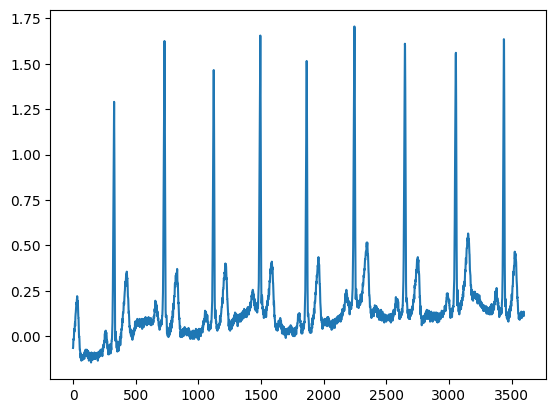

In [68]:
df[df["label"]=="NSR"].iloc[0,:-2].plot()


## Creación del DATALOADER

In [53]:
class ECGDataset(Dataset):

    def __init__(self, df):
        self.df = df
        self.data_columns = self.df.columns[:-2].tolist()
        # Pre-convertir los datos a arrays numpy para evitar warnings
        self.signals = self.df[self.data_columns].values.astype('float32')
        self.targets = self.df['class'].values.astype('int64')

    def __getitem__(self, idx):
        signal = torch.from_numpy(self.signals[idx]).unsqueeze(0)
        target = torch.tensor(self.targets[idx], dtype=torch.long)
        return signal, target

    def __len__(self):
        return len(self.df)

def get_dataloader(label_name, batch_size):
    df = pd.read_csv(config.csv_path)
    df = df.loc[df['label'] == label_name]
    df.reset_index(drop=True, inplace=True)
    dataset = ECGDataset(df)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0)
    return dataloader

In [54]:
dataloader = get_dataloader(label_name='NSR', batch_size=96)

print(len(dataloader))
x,y = next(iter(dataloader))
x.shape, y.shape

3


(torch.Size([96, 1, 3600]), torch.Size([96]))

## CREACION DEL GAN

In [60]:
import torch.nn as nn
import torch.nn.functional as F


class Generator(nn.Module):
    def __init__(self, signal_length=3600):
        super(Generator, self).__init__()
        self.signal_length = signal_length
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, signal_length)
        self.rnn_layer = nn.LSTM(
                input_size=signal_length,
                hidden_size=128,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 256)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = self.fc3(x)
        return x.unsqueeze(1)


class Discriminator(nn.Module):
    def __init__(self, signal_length=3600):
        super(Discriminator, self).__init__()
        self.signal_length = signal_length
        
        self.rnn_layer = nn.LSTM(
                input_size=signal_length,
                hidden_size=256,
                num_layers=1,
                bidirectional=True,
                batch_first=True,
            )
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 256) 
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x,_ = self.rnn_layer(x)
        x = x.view(-1, 512)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        x = torch.sigmoid(self.fc3(x))
        return x

In [61]:
class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        batch_size,
        num_epochs,
        label,
        signal_length=3600
    ):
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        self.netG = generator.to(self.device)
        self.netD = discriminator.to(self.device)
        
        self.optimizerD = Adam(self.netD.parameters(), lr=0.0002)
        self.optimizerG = Adam(self.netG.parameters(), lr=0.0002)
        self.criterion = nn.BCELoss()
        
        self.batch_size = batch_size
        self.signal_length = signal_length
        self.signal_dim = [self.batch_size, 1, self.signal_length]
        self.num_epochs = num_epochs
        self.dataloader = get_dataloader(
            label_name=label, batch_size=self.batch_size
        )
        self.fixed_noise = torch.randn(self.batch_size, 1, self.signal_length,
                                       device=self.device)
        self.g_errors = []
        self.d_errors = []
        
    def _one_epoch(self):
        real_label = 1
        fake_label = 0
        
        for i, data in enumerate(self.dataloader, 0):
            ##### Update Discriminator: maximize log(D(x)) + log(1 - D(G(z))) #####
            ## train with real data
            self.netD.zero_grad()
            real_data = data[0].to(self.device)
            # dim for noise
            batch_size = real_data.size(0)
            self.signal_dim[0] = batch_size
            
            label = torch.full((batch_size,), real_label,
                           dtype=real_data.dtype, device=self.device)
            
            output = self.netD(real_data)
            output = output.view(-1)
       
            errD_real = self.criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()
            
            ## train with fake data
            noise = torch.randn(self.signal_dim, device=self.device)
            fake = self.netG(noise)
            label.fill_(fake_label)
            
            output = self.netD(fake.detach())
            output = output.view(-1)
            
            errD_fake = self.criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake 
            self.optimizerD.step()
            
            ##### Update Generator: maximaze log(D(G(z)))  
            self.netG.zero_grad()
            label.fill_(real_label) 
            output = self.netD(fake)
            output = output.view(-1)
            
            errG = self.criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            self.optimizerG.step()
            
        return errD.item(), errG.item()
        
    def run(self):
        print(f"Iniciando entrenamiento en {self.device}")
        print(f"Signal length: {self.signal_length}")
        print(f"Batch size: {self.batch_size}")
        print(f"Número de batches: {len(self.dataloader)}")
        print("-" * 60)
        
        for epoch in range(self.num_epochs):
            errD_, errG_ = self._one_epoch()
            self.d_errors.append(errD_)
            self.g_errors.append(errG_)
            if epoch % 50 == 0:
                print(f"Epoch: {epoch} | Loss_D: {errD_:.4f} | Loss_G: {errG_:.4f} | Time: {time.strftime('%H:%M:%S')}")
   
            if epoch % 100 == 0:
                fake = self.netG(self.fixed_noise)
                plt.figure(figsize=(12, 4))
                plt.plot(fake.detach().cpu().squeeze(1).numpy()[:5].transpose())
                plt.title(f'Señales generadas - Época {epoch}')
                plt.xlabel('Muestras')
                plt.ylabel('Amplitud')
                plt.grid(ls=":", alpha=0.5)
                plt.show()
            
        # Guardar modelos correctamente
        torch.save(self.netG.state_dict(), "../resultados/generator.pth")
        torch.save(self.netD.state_dict(), "../resultados/discriminator.pth")
        print("Modelos guardados exitosamente!")

In [62]:
g = Generator(signal_length=3600)
d = Discriminator(signal_length=3600)

print(f"Generator parameters: {sum(p.numel() for p in g.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in d.parameters()):,}")

Generator parameters: 8,166,416
Discriminator parameters: 8,295,425


Iniciando entrenamiento en cuda:0
Signal length: 3600
Batch size: 96
Número de batches: 3
------------------------------------------------------------
Epoch: 0 | Loss_D: 0.0000 | Loss_G: 27.1712 | Time: 15:45:19


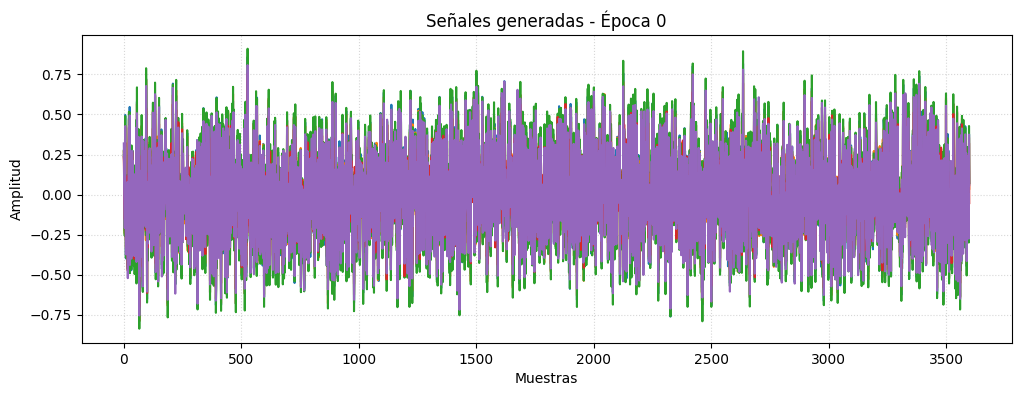

Epoch: 50 | Loss_D: 0.0000 | Loss_G: 18.7758 | Time: 15:45:20
Epoch: 100 | Loss_D: 0.0000 | Loss_G: 38.1474 | Time: 15:45:21
Epoch: 100 | Loss_D: 0.0000 | Loss_G: 38.1474 | Time: 15:45:21


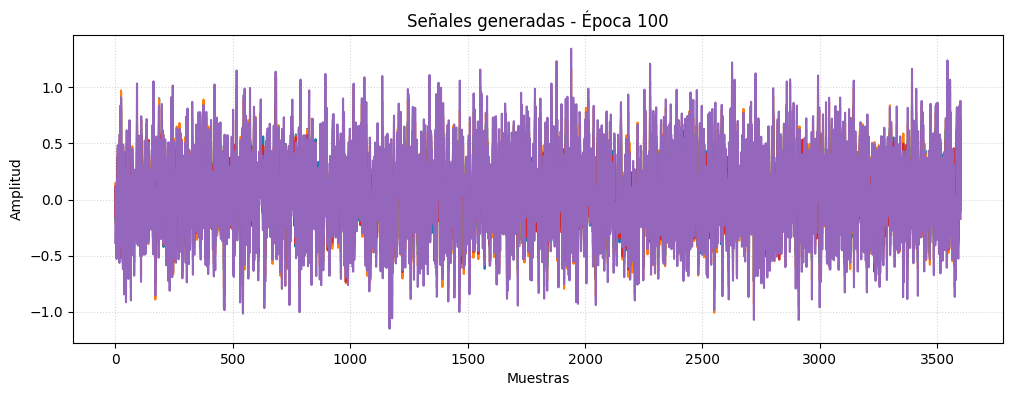

Epoch: 150 | Loss_D: 0.0000 | Loss_G: 50.0350 | Time: 15:45:22
Epoch: 200 | Loss_D: 0.0000 | Loss_G: 50.0458 | Time: 15:45:23
Epoch: 200 | Loss_D: 0.0000 | Loss_G: 50.0458 | Time: 15:45:23


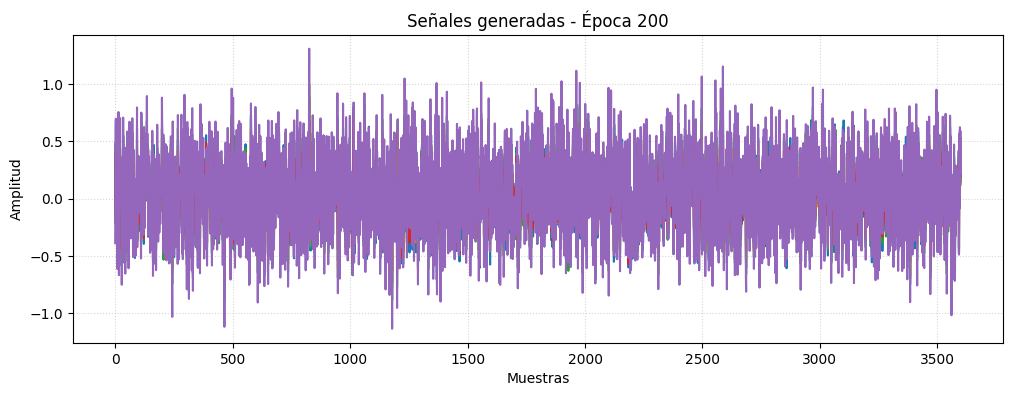

Epoch: 250 | Loss_D: 0.0000 | Loss_G: 48.7994 | Time: 15:45:23
Epoch: 300 | Loss_D: 0.0000 | Loss_G: 49.5999 | Time: 15:45:24
Epoch: 300 | Loss_D: 0.0000 | Loss_G: 49.5999 | Time: 15:45:24


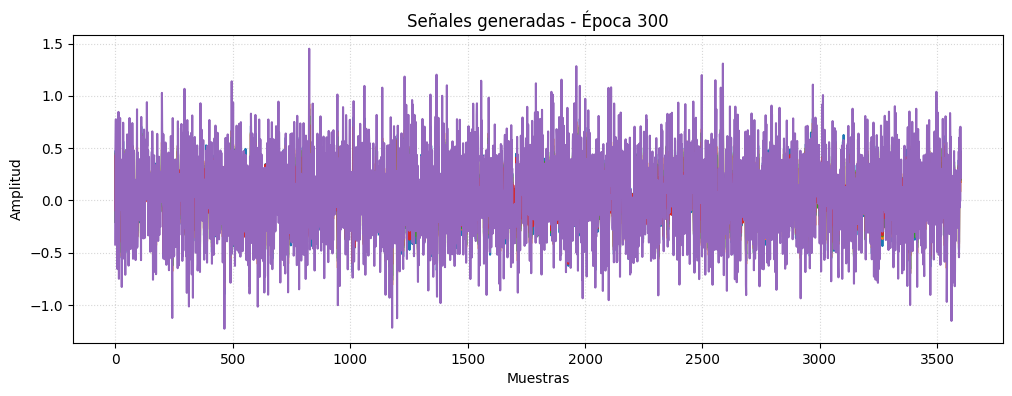

Epoch: 350 | Loss_D: 0.0000 | Loss_G: 48.9755 | Time: 15:45:25
Epoch: 400 | Loss_D: 0.0000 | Loss_G: 48.8232 | Time: 15:45:26
Epoch: 400 | Loss_D: 0.0000 | Loss_G: 48.8232 | Time: 15:45:26


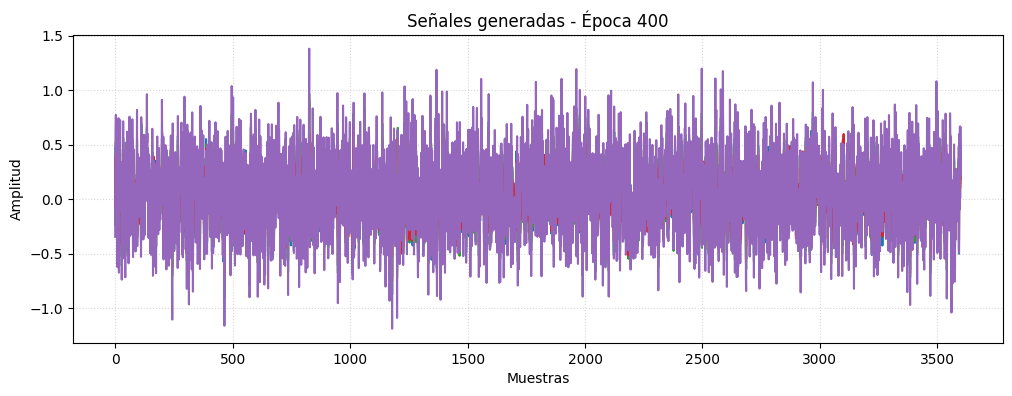

Epoch: 450 | Loss_D: 0.0000 | Loss_G: 49.4739 | Time: 15:45:27
Epoch: 500 | Loss_D: 0.0000 | Loss_G: 50.0493 | Time: 15:45:27
Epoch: 500 | Loss_D: 0.0000 | Loss_G: 50.0493 | Time: 15:45:27


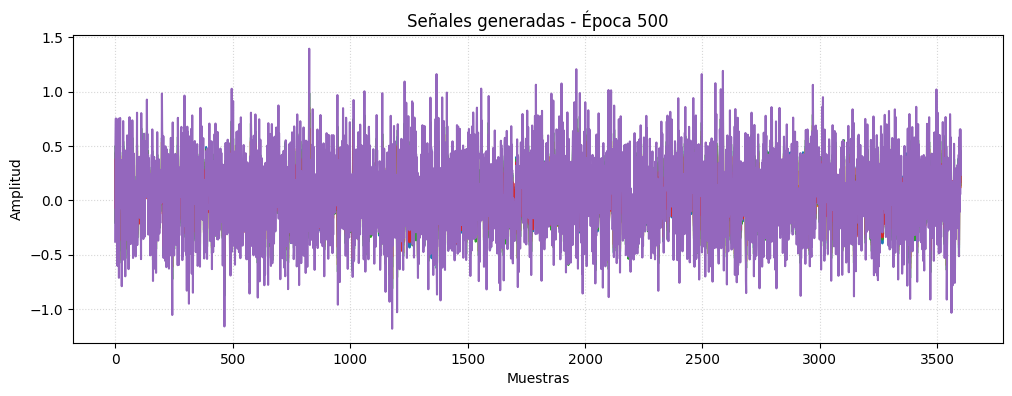

Epoch: 550 | Loss_D: 0.0000 | Loss_G: 49.5118 | Time: 15:45:28
Epoch: 600 | Loss_D: 0.0000 | Loss_G: 49.4325 | Time: 15:45:29
Epoch: 600 | Loss_D: 0.0000 | Loss_G: 49.4325 | Time: 15:45:29


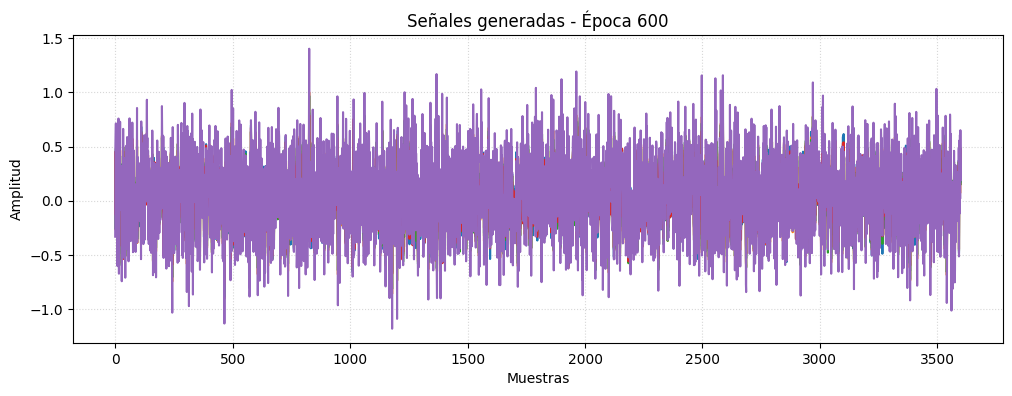

Epoch: 650 | Loss_D: 0.0000 | Loss_G: 49.1862 | Time: 15:45:30
Epoch: 700 | Loss_D: 0.0000 | Loss_G: 49.6480 | Time: 15:45:31
Epoch: 700 | Loss_D: 0.0000 | Loss_G: 49.6480 | Time: 15:45:31


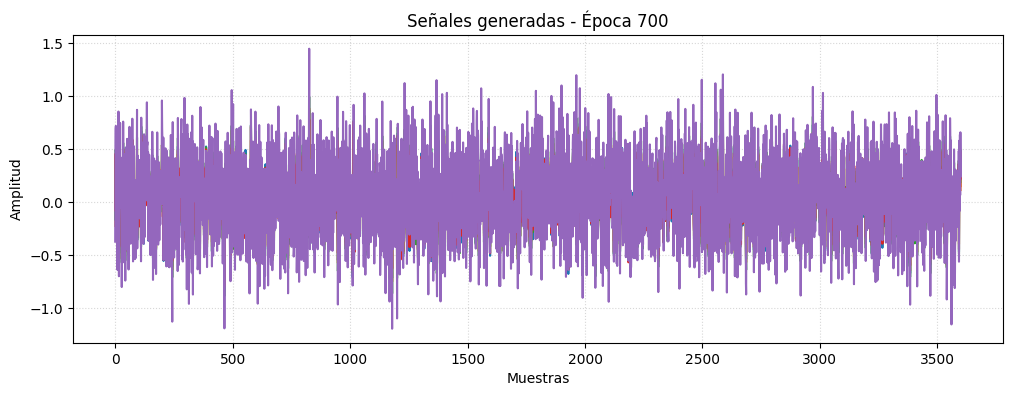

Epoch: 750 | Loss_D: 0.0000 | Loss_G: 50.5603 | Time: 15:45:32
Epoch: 800 | Loss_D: 0.0000 | Loss_G: 49.5635 | Time: 15:45:32
Epoch: 800 | Loss_D: 0.0000 | Loss_G: 49.5635 | Time: 15:45:32


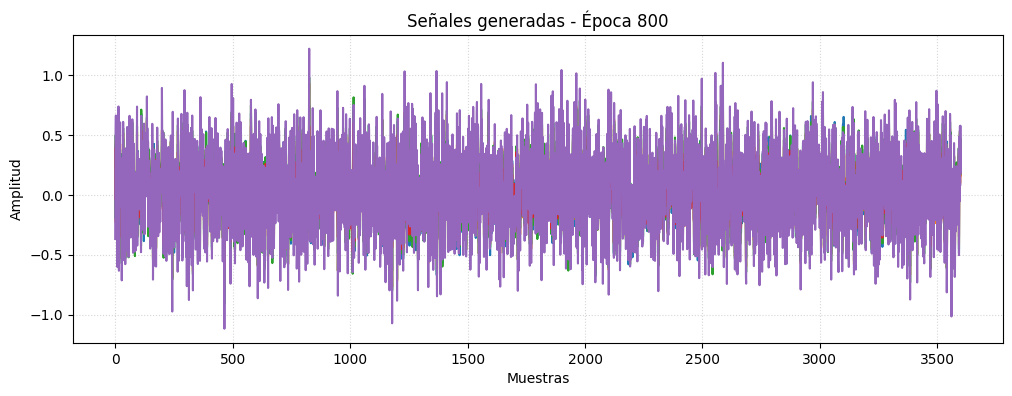

Epoch: 850 | Loss_D: 0.0000 | Loss_G: 49.6894 | Time: 15:45:33
Epoch: 900 | Loss_D: 0.0000 | Loss_G: 48.3836 | Time: 15:45:34
Epoch: 900 | Loss_D: 0.0000 | Loss_G: 48.3836 | Time: 15:45:34


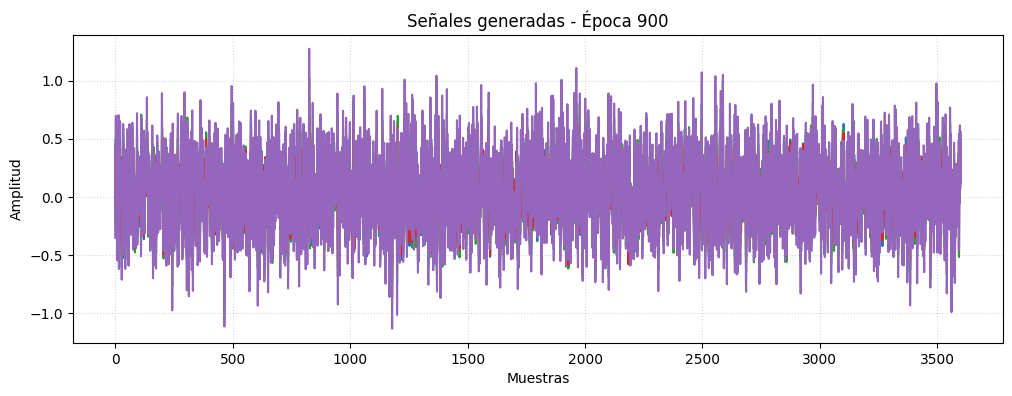

Epoch: 950 | Loss_D: 0.0000 | Loss_G: 48.7714 | Time: 15:45:35
Epoch: 1000 | Loss_D: 0.0000 | Loss_G: 94.1223 | Time: 15:45:36
Epoch: 1000 | Loss_D: 0.0000 | Loss_G: 94.1223 | Time: 15:45:36


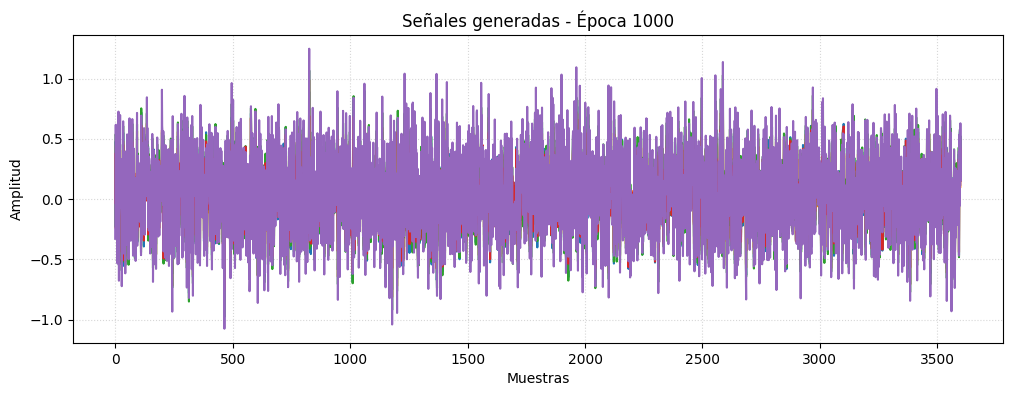

Epoch: 1050 | Loss_D: 0.0000 | Loss_G: 96.9863 | Time: 15:45:36
Epoch: 1100 | Loss_D: 0.0000 | Loss_G: 97.7047 | Time: 15:45:37
Epoch: 1100 | Loss_D: 0.0000 | Loss_G: 97.7047 | Time: 15:45:37


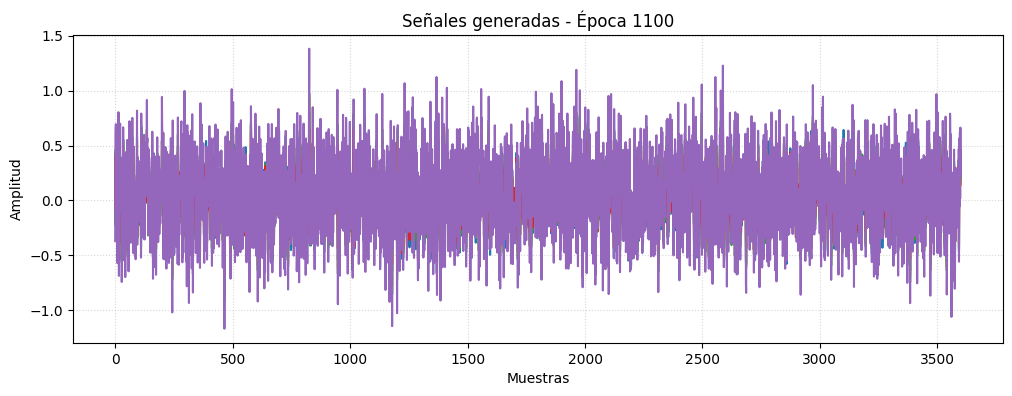

Epoch: 1150 | Loss_D: 0.0000 | Loss_G: 97.7489 | Time: 15:45:38
Epoch: 1200 | Loss_D: 0.0000 | Loss_G: 96.6153 | Time: 15:45:39
Epoch: 1200 | Loss_D: 0.0000 | Loss_G: 96.6153 | Time: 15:45:39


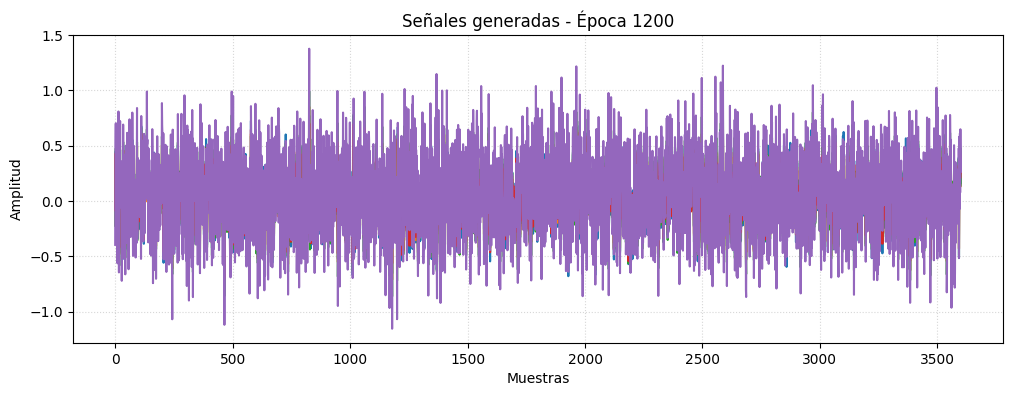

Epoch: 1250 | Loss_D: 0.0000 | Loss_G: 98.2582 | Time: 15:45:40
Epoch: 1300 | Loss_D: 0.0000 | Loss_G: 97.8286 | Time: 15:45:41
Epoch: 1300 | Loss_D: 0.0000 | Loss_G: 97.8286 | Time: 15:45:41


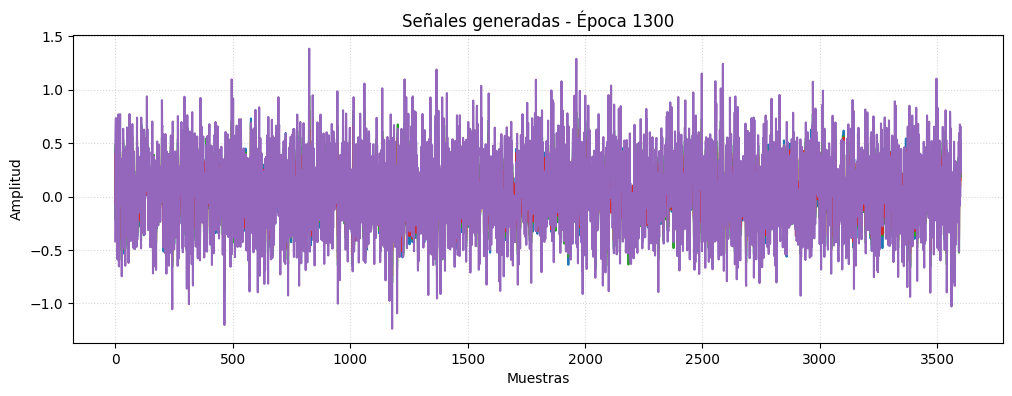

Epoch: 1350 | Loss_D: 0.0000 | Loss_G: 98.2471 | Time: 15:45:41
Epoch: 1400 | Loss_D: 0.0000 | Loss_G: 97.3341 | Time: 15:45:42
Epoch: 1400 | Loss_D: 0.0000 | Loss_G: 97.3341 | Time: 15:45:42


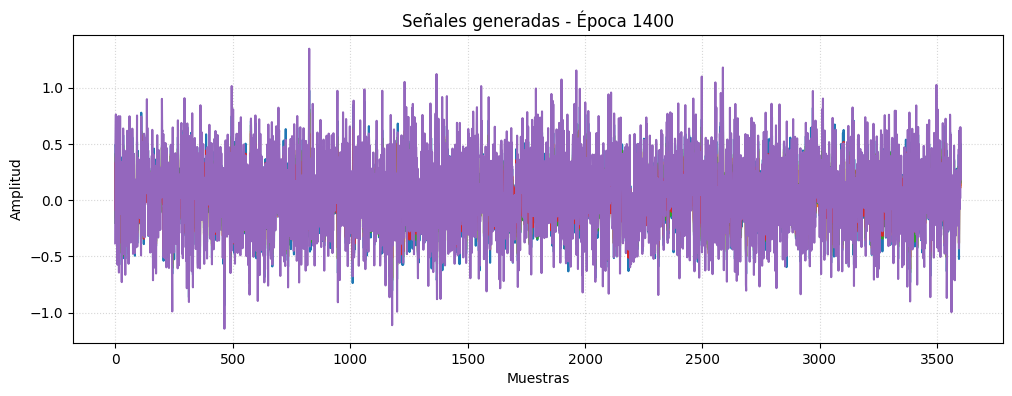

Epoch: 1450 | Loss_D: 0.0000 | Loss_G: 98.0223 | Time: 15:45:43
Epoch: 1500 | Loss_D: 0.0000 | Loss_G: 98.2505 | Time: 15:45:44
Epoch: 1500 | Loss_D: 0.0000 | Loss_G: 98.2505 | Time: 15:45:44


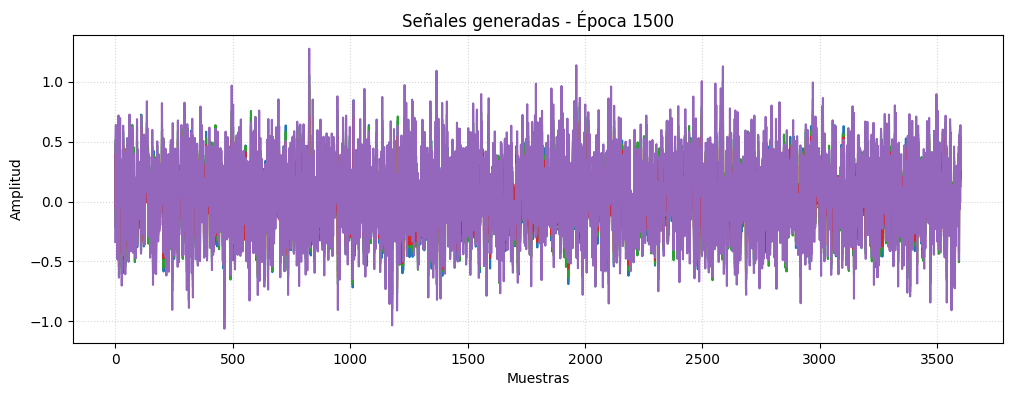

Epoch: 1550 | Loss_D: 0.0000 | Loss_G: 97.6774 | Time: 15:45:45
Epoch: 1600 | Loss_D: 0.0000 | Loss_G: 98.6533 | Time: 15:45:46
Epoch: 1600 | Loss_D: 0.0000 | Loss_G: 98.6533 | Time: 15:45:46


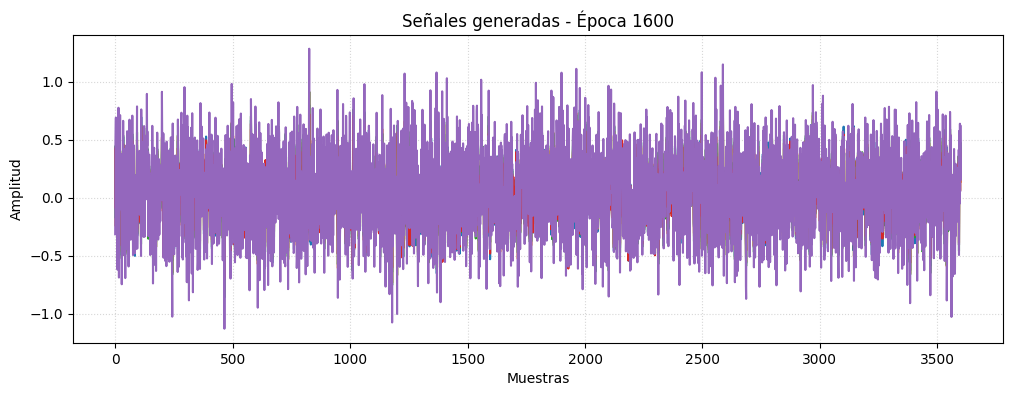

Epoch: 1650 | Loss_D: 0.0000 | Loss_G: 97.8046 | Time: 15:45:46
Epoch: 1700 | Loss_D: 0.0000 | Loss_G: 97.9665 | Time: 15:45:47
Epoch: 1700 | Loss_D: 0.0000 | Loss_G: 97.9665 | Time: 15:45:47


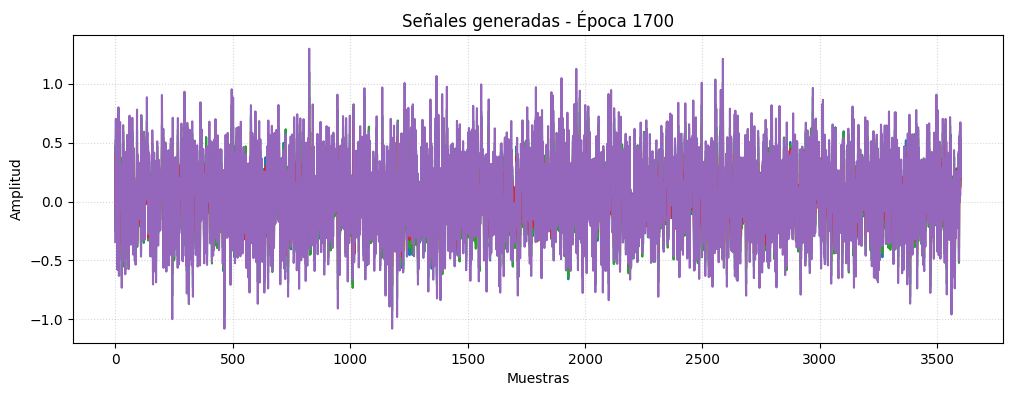

Epoch: 1750 | Loss_D: 0.0000 | Loss_G: 98.0416 | Time: 15:45:48
Epoch: 1800 | Loss_D: 0.0000 | Loss_G: 97.7684 | Time: 15:45:49
Epoch: 1800 | Loss_D: 0.0000 | Loss_G: 97.7684 | Time: 15:45:49


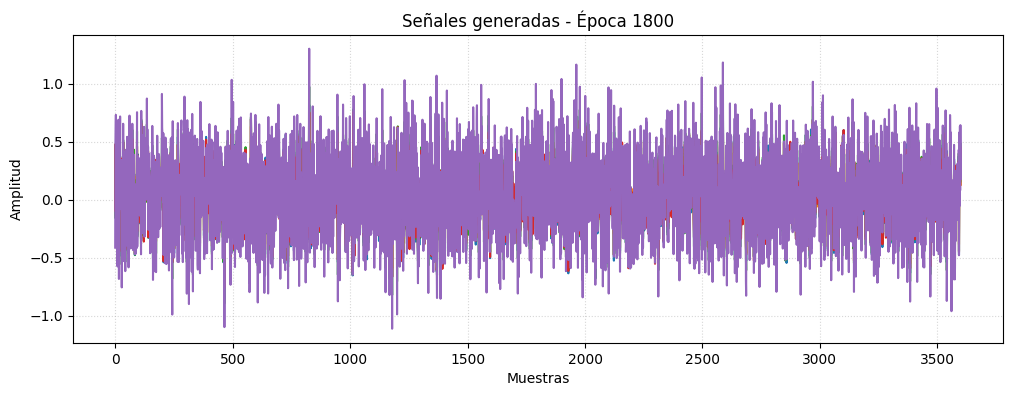

Epoch: 1850 | Loss_D: 0.0000 | Loss_G: 97.6984 | Time: 15:45:50
Epoch: 1900 | Loss_D: 0.0000 | Loss_G: 97.8230 | Time: 15:45:51
Epoch: 1900 | Loss_D: 0.0000 | Loss_G: 97.8230 | Time: 15:45:51


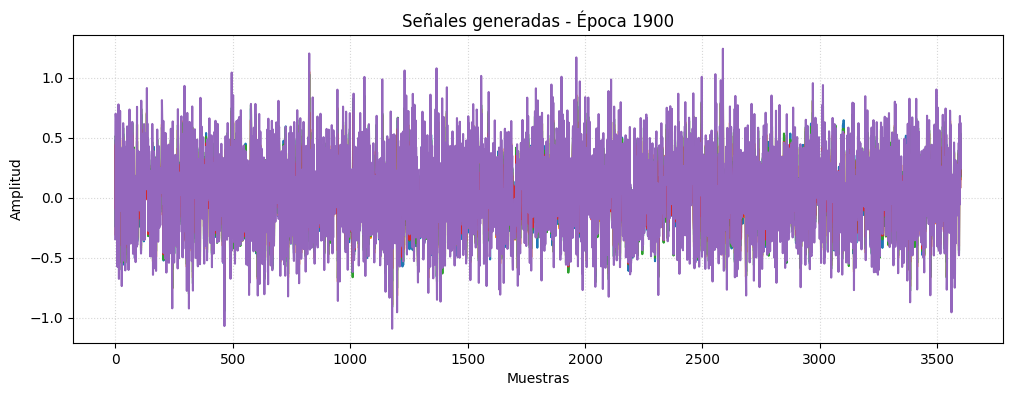

Epoch: 1950 | Loss_D: 0.0000 | Loss_G: 97.7523 | Time: 15:45:51
Epoch: 2000 | Loss_D: 0.0000 | Loss_G: 98.0608 | Time: 15:45:52
Epoch: 2000 | Loss_D: 0.0000 | Loss_G: 98.0608 | Time: 15:45:52


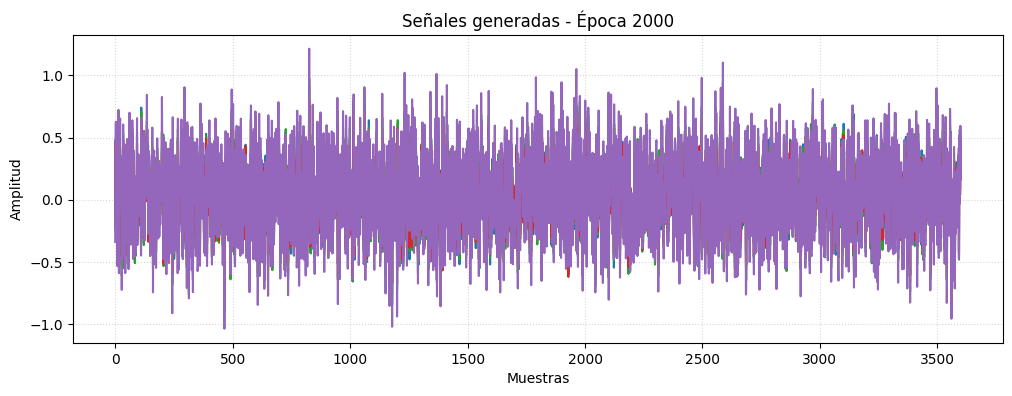

Epoch: 2050 | Loss_D: 0.0000 | Loss_G: 97.6551 | Time: 15:45:53
Epoch: 2100 | Loss_D: 0.0000 | Loss_G: 96.6011 | Time: 15:45:54
Epoch: 2100 | Loss_D: 0.0000 | Loss_G: 96.6011 | Time: 15:45:54


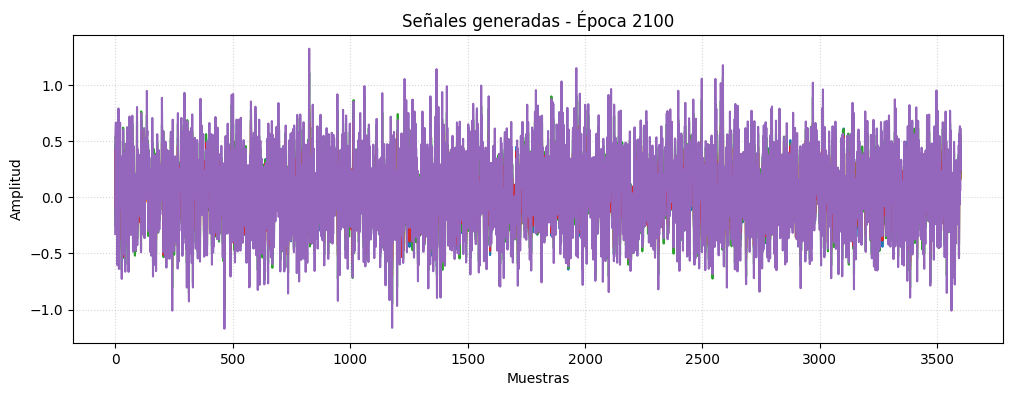

Epoch: 2150 | Loss_D: 0.0000 | Loss_G: 98.4634 | Time: 15:45:55
Epoch: 2200 | Loss_D: 0.0000 | Loss_G: 97.8876 | Time: 15:45:56
Epoch: 2200 | Loss_D: 0.0000 | Loss_G: 97.8876 | Time: 15:45:56


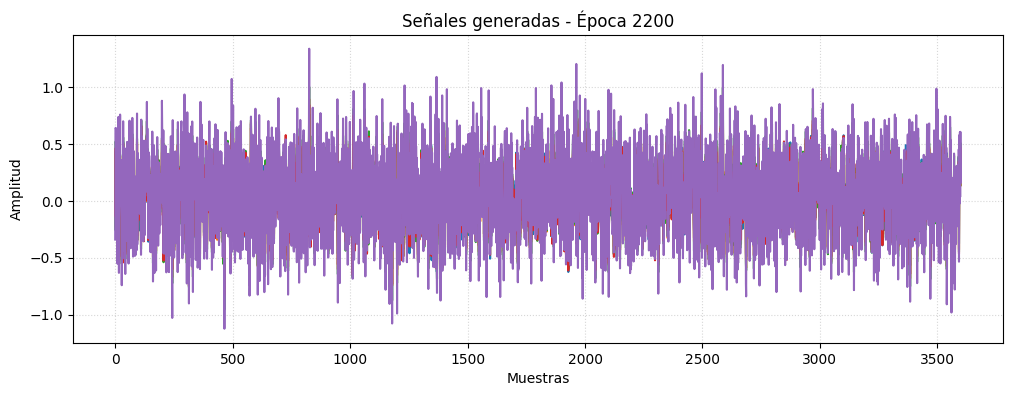

Epoch: 2250 | Loss_D: 0.0000 | Loss_G: 98.4735 | Time: 15:45:56
Epoch: 2300 | Loss_D: 0.0000 | Loss_G: 98.5627 | Time: 15:45:57
Epoch: 2300 | Loss_D: 0.0000 | Loss_G: 98.5627 | Time: 15:45:57


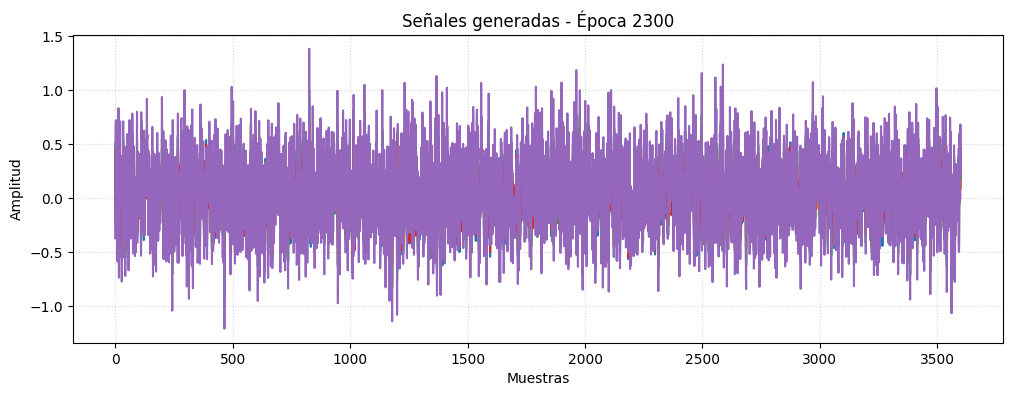

Epoch: 2350 | Loss_D: 0.0000 | Loss_G: 98.0265 | Time: 15:45:58
Epoch: 2400 | Loss_D: 0.0000 | Loss_G: 98.1894 | Time: 15:45:59
Epoch: 2400 | Loss_D: 0.0000 | Loss_G: 98.1894 | Time: 15:45:59


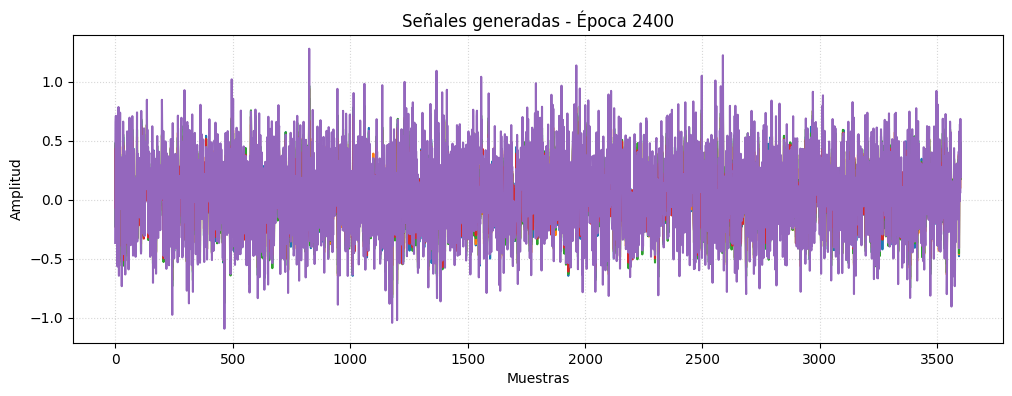

Epoch: 2450 | Loss_D: 0.0000 | Loss_G: 97.7499 | Time: 15:46:00
Epoch: 2500 | Loss_D: 0.0000 | Loss_G: 98.3967 | Time: 15:46:01
Epoch: 2500 | Loss_D: 0.0000 | Loss_G: 98.3967 | Time: 15:46:01


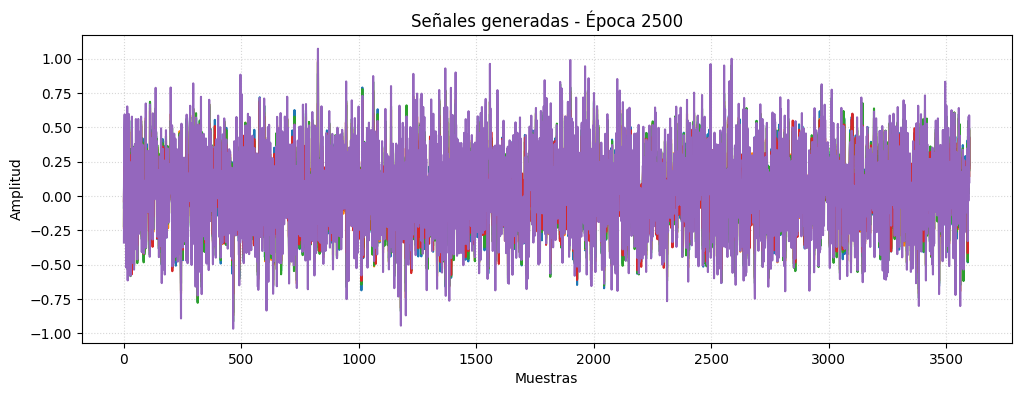

Epoch: 2550 | Loss_D: 0.0000 | Loss_G: 98.3780 | Time: 15:46:01
Epoch: 2600 | Loss_D: 0.0000 | Loss_G: 98.2495 | Time: 15:46:02
Epoch: 2600 | Loss_D: 0.0000 | Loss_G: 98.2495 | Time: 15:46:02


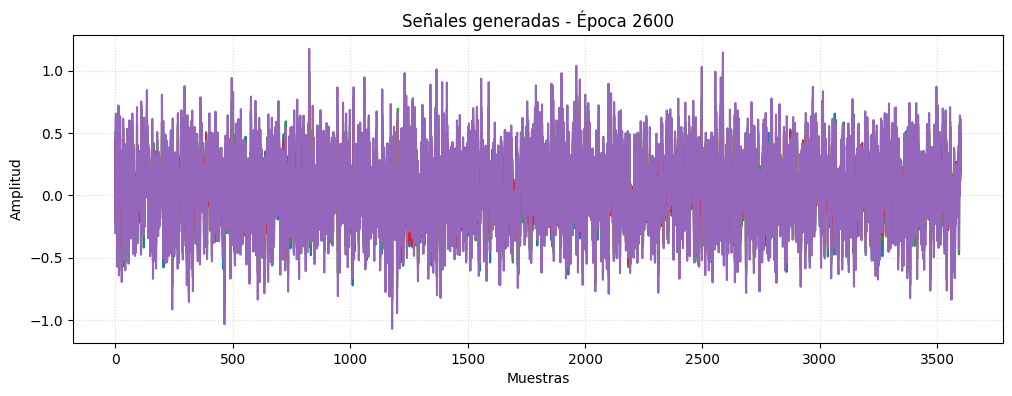

Epoch: 2650 | Loss_D: 0.0000 | Loss_G: 98.2687 | Time: 15:46:03
Epoch: 2700 | Loss_D: 0.0000 | Loss_G: 97.1018 | Time: 15:46:04
Epoch: 2700 | Loss_D: 0.0000 | Loss_G: 97.1018 | Time: 15:46:04


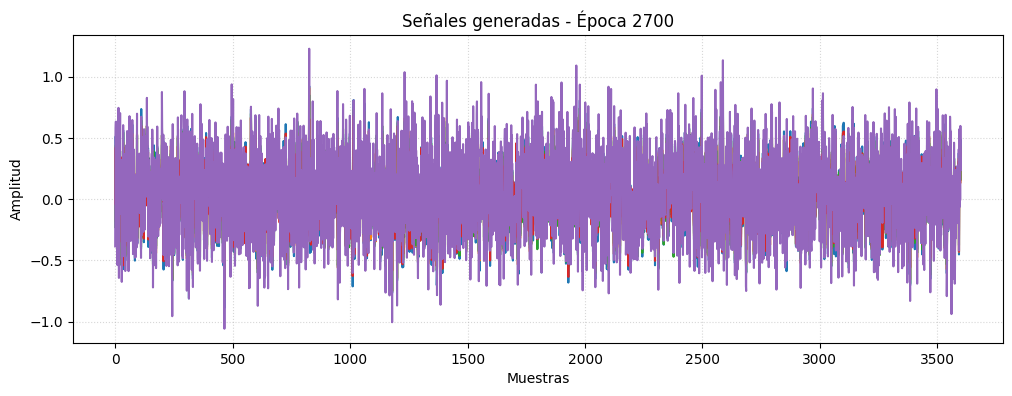

Epoch: 2750 | Loss_D: 0.0000 | Loss_G: 97.0424 | Time: 15:46:05
Epoch: 2800 | Loss_D: 0.0000 | Loss_G: 98.0160 | Time: 15:46:06
Epoch: 2800 | Loss_D: 0.0000 | Loss_G: 98.0160 | Time: 15:46:06


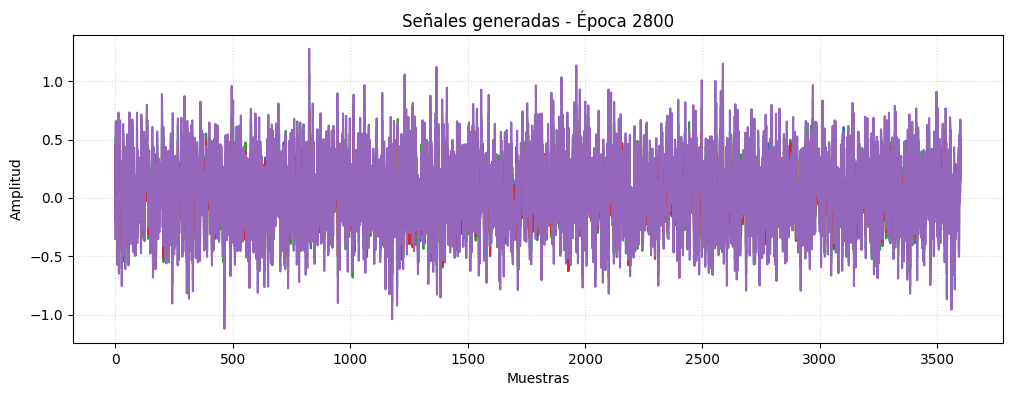

Epoch: 2850 | Loss_D: 0.0000 | Loss_G: 98.7941 | Time: 15:46:06
Epoch: 2900 | Loss_D: 0.0000 | Loss_G: 97.0571 | Time: 15:46:07
Epoch: 2900 | Loss_D: 0.0000 | Loss_G: 97.0571 | Time: 15:46:07


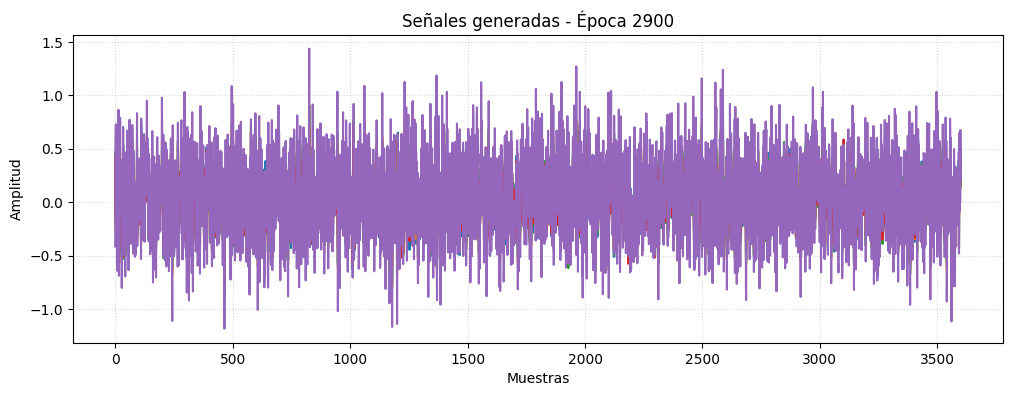

Epoch: 2950 | Loss_D: 0.0000 | Loss_G: 99.0440 | Time: 15:46:08
Epoch: 3000 | Loss_D: 0.0000 | Loss_G: 97.8118 | Time: 15:46:09
Epoch: 3000 | Loss_D: 0.0000 | Loss_G: 97.8118 | Time: 15:46:09


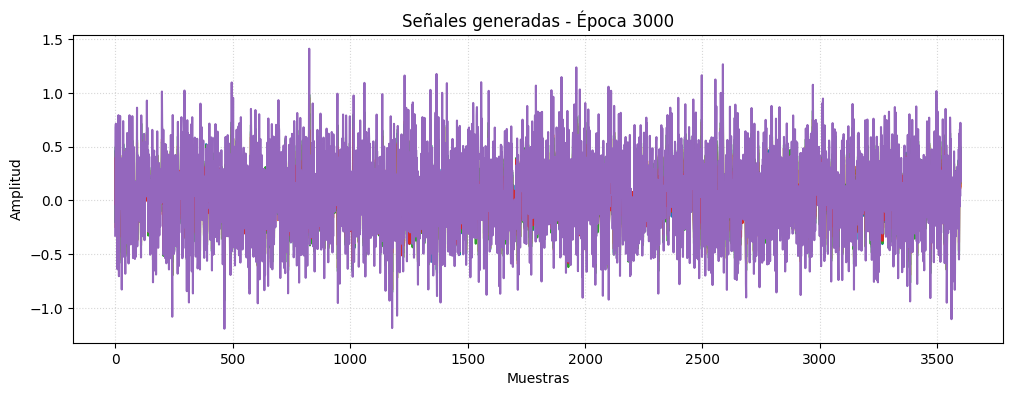

Epoch: 3050 | Loss_D: 0.0000 | Loss_G: 97.5525 | Time: 15:46:10
Epoch: 3100 | Loss_D: 0.0000 | Loss_G: 98.0846 | Time: 15:46:10
Epoch: 3100 | Loss_D: 0.0000 | Loss_G: 98.0846 | Time: 15:46:10


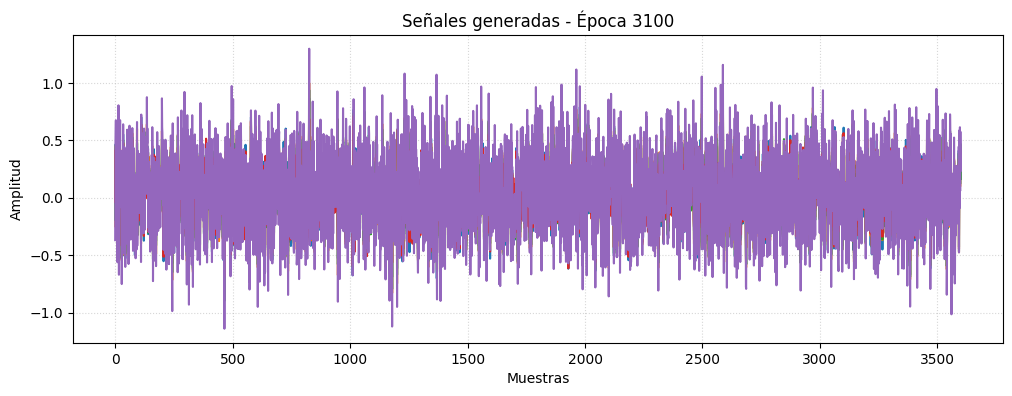

Epoch: 3150 | Loss_D: 0.0000 | Loss_G: 97.3780 | Time: 15:46:11
Epoch: 3200 | Loss_D: 0.0000 | Loss_G: 97.1686 | Time: 15:46:12
Epoch: 3200 | Loss_D: 0.0000 | Loss_G: 97.1686 | Time: 15:46:12


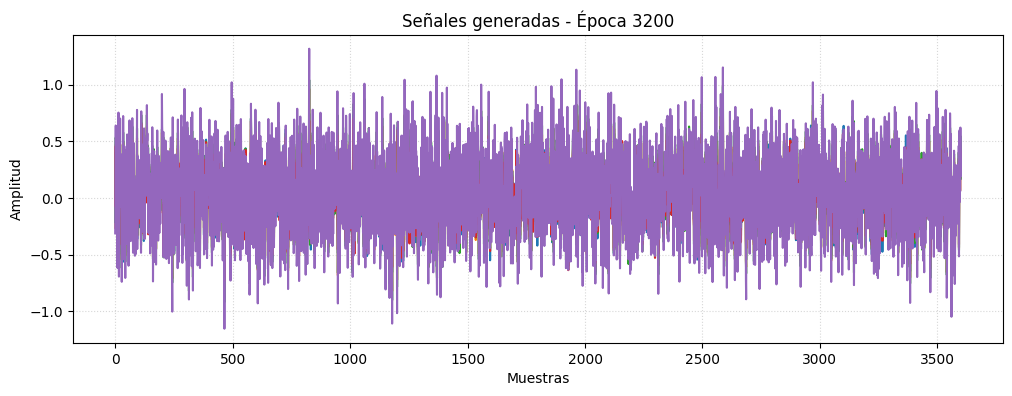

Epoch: 3250 | Loss_D: 0.0000 | Loss_G: 97.7579 | Time: 15:46:13
Epoch: 3300 | Loss_D: 0.0000 | Loss_G: 96.9340 | Time: 15:46:14
Epoch: 3300 | Loss_D: 0.0000 | Loss_G: 96.9340 | Time: 15:46:14


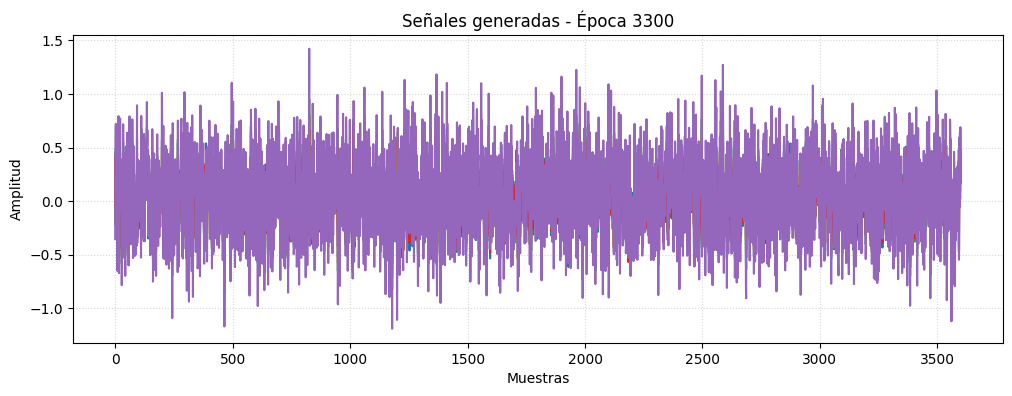

Epoch: 3350 | Loss_D: 0.0000 | Loss_G: 96.4316 | Time: 15:46:15
Epoch: 3400 | Loss_D: 0.0000 | Loss_G: 98.7609 | Time: 15:46:15
Epoch: 3400 | Loss_D: 0.0000 | Loss_G: 98.7609 | Time: 15:46:15


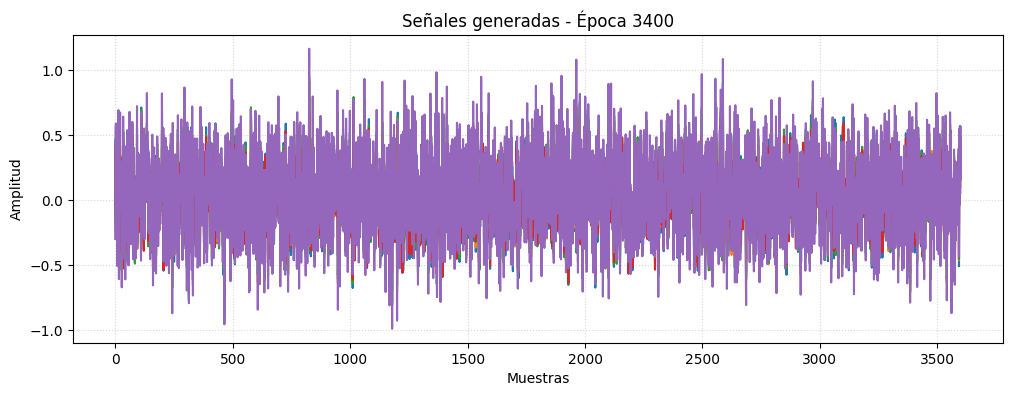

Epoch: 3450 | Loss_D: 0.0000 | Loss_G: 97.4577 | Time: 15:46:16
Epoch: 3500 | Loss_D: 0.0000 | Loss_G: 97.9742 | Time: 15:46:17
Epoch: 3500 | Loss_D: 0.0000 | Loss_G: 97.9742 | Time: 15:46:17


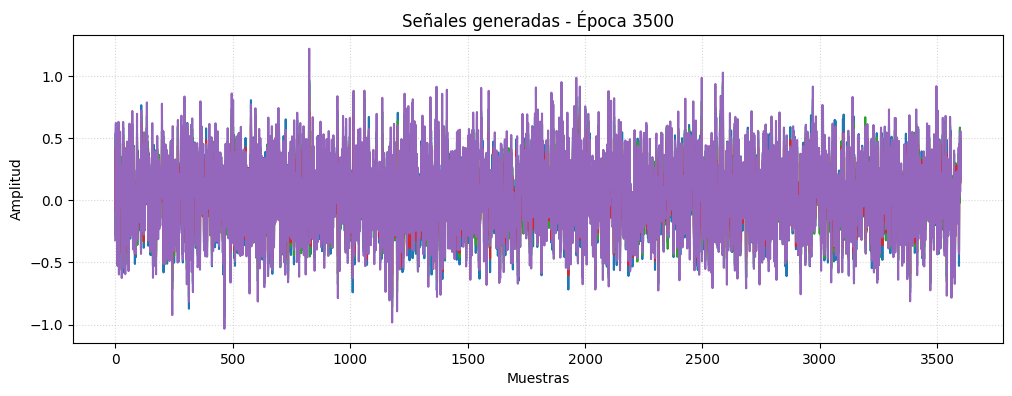

Epoch: 3550 | Loss_D: 0.0000 | Loss_G: 98.5939 | Time: 15:46:18
Epoch: 3600 | Loss_D: 0.0000 | Loss_G: 96.4579 | Time: 15:46:19
Epoch: 3600 | Loss_D: 0.0000 | Loss_G: 96.4579 | Time: 15:46:19


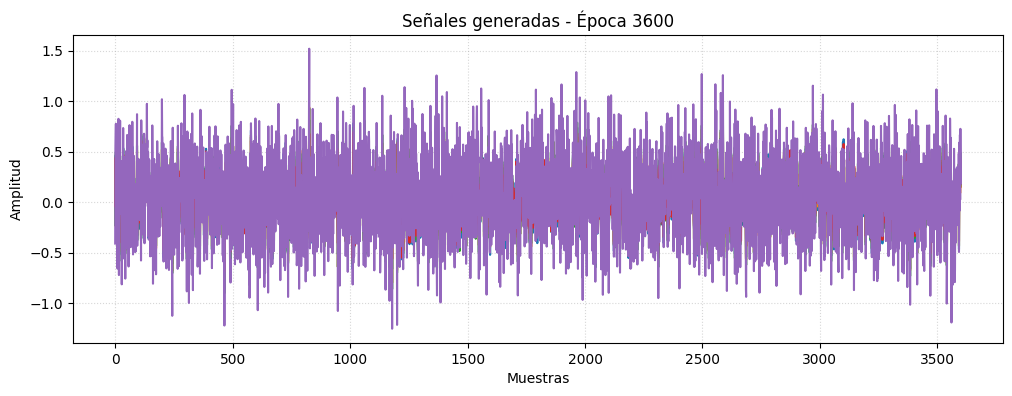

Epoch: 3650 | Loss_D: 0.0000 | Loss_G: 97.8621 | Time: 15:46:20
Epoch: 3700 | Loss_D: 0.0000 | Loss_G: 96.7445 | Time: 15:46:20
Epoch: 3700 | Loss_D: 0.0000 | Loss_G: 96.7445 | Time: 15:46:20


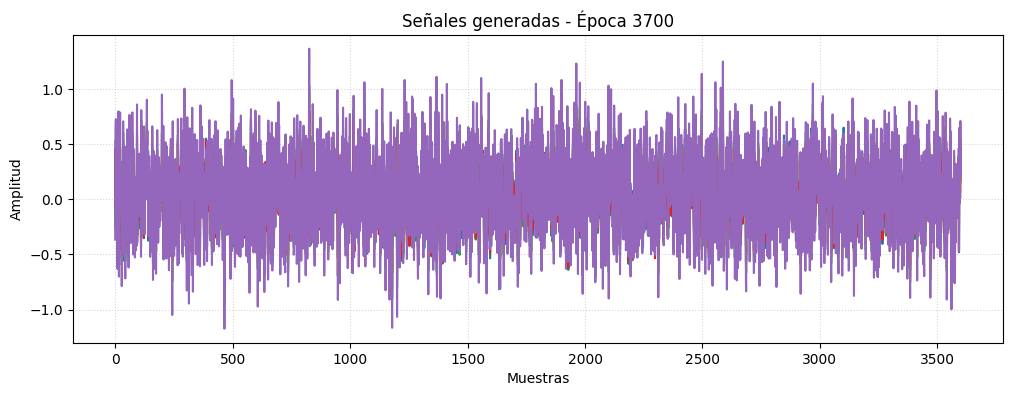

Epoch: 3750 | Loss_D: 0.0000 | Loss_G: 97.7245 | Time: 15:46:21
Epoch: 3800 | Loss_D: 0.0000 | Loss_G: 97.3771 | Time: 15:46:22
Epoch: 3800 | Loss_D: 0.0000 | Loss_G: 97.3771 | Time: 15:46:22


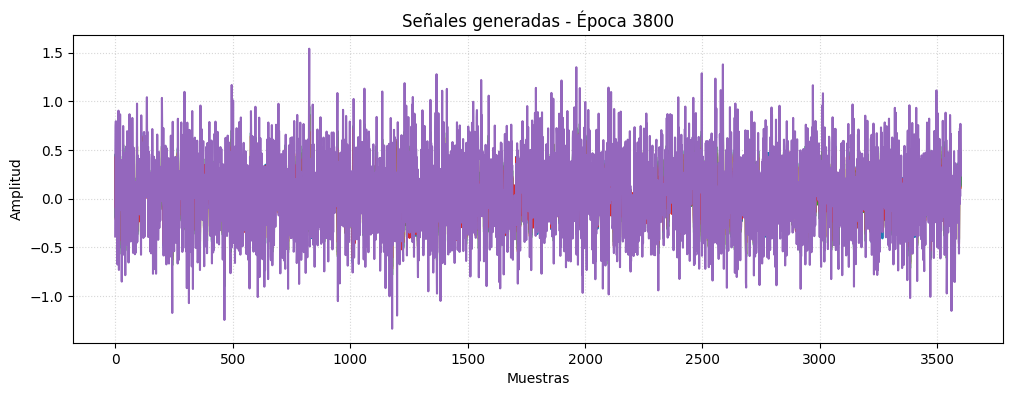

Epoch: 3850 | Loss_D: 0.0000 | Loss_G: 98.1716 | Time: 15:46:23
Epoch: 3900 | Loss_D: 0.0000 | Loss_G: 98.2191 | Time: 15:46:24
Epoch: 3900 | Loss_D: 0.0000 | Loss_G: 98.2191 | Time: 15:46:24


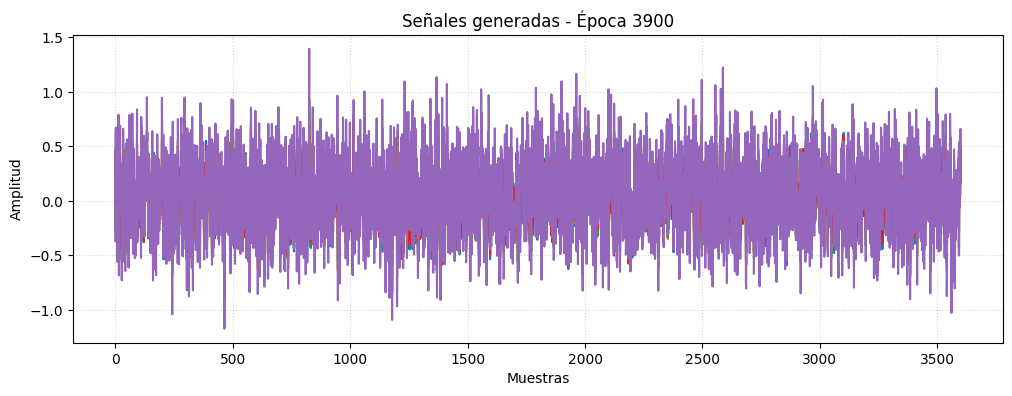

Epoch: 3950 | Loss_D: 0.0000 | Loss_G: 97.0481 | Time: 15:46:25
Epoch: 4000 | Loss_D: 0.0000 | Loss_G: 99.2679 | Time: 15:46:25
Epoch: 4000 | Loss_D: 0.0000 | Loss_G: 99.2679 | Time: 15:46:25


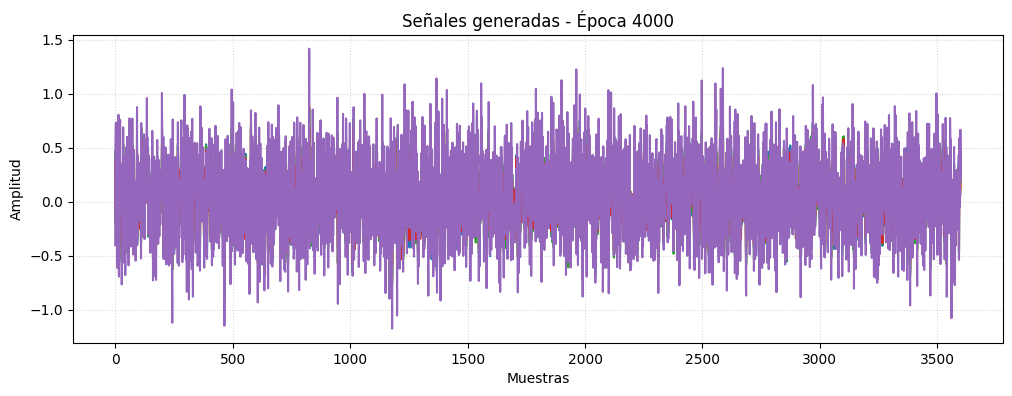

Epoch: 4050 | Loss_D: 0.0000 | Loss_G: 97.3848 | Time: 15:46:26
Epoch: 4100 | Loss_D: 0.0000 | Loss_G: 96.7957 | Time: 15:46:27
Epoch: 4100 | Loss_D: 0.0000 | Loss_G: 96.7957 | Time: 15:46:27


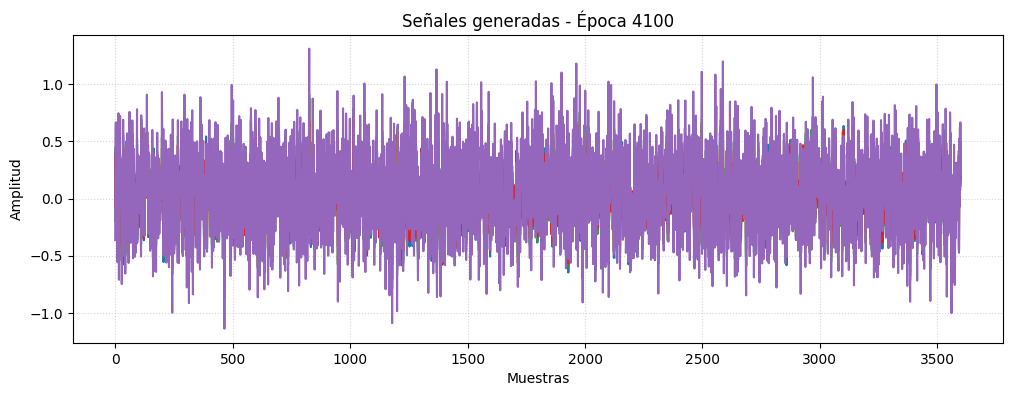

Epoch: 4150 | Loss_D: 0.0000 | Loss_G: 97.4429 | Time: 15:46:28
Epoch: 4200 | Loss_D: 0.0000 | Loss_G: 97.4535 | Time: 15:46:29
Epoch: 4200 | Loss_D: 0.0000 | Loss_G: 97.4535 | Time: 15:46:29


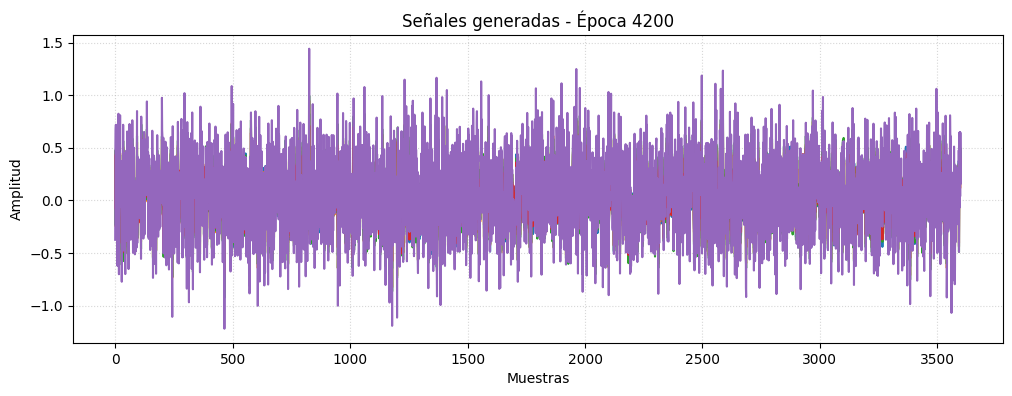

Epoch: 4250 | Loss_D: 0.0000 | Loss_G: 97.4732 | Time: 15:46:30
Epoch: 4300 | Loss_D: 0.0000 | Loss_G: 96.7098 | Time: 15:46:30
Epoch: 4300 | Loss_D: 0.0000 | Loss_G: 96.7098 | Time: 15:46:30


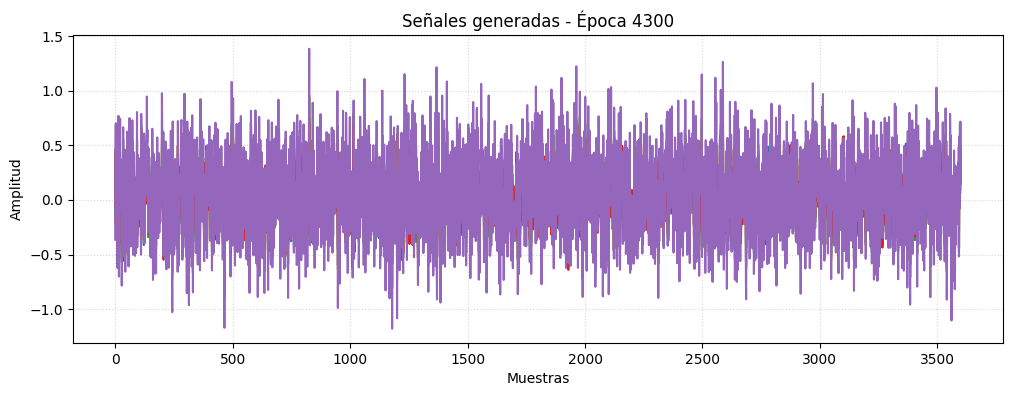

Epoch: 4350 | Loss_D: 0.0000 | Loss_G: 98.3033 | Time: 15:46:31
Epoch: 4400 | Loss_D: 0.0000 | Loss_G: 97.0836 | Time: 15:46:32
Epoch: 4400 | Loss_D: 0.0000 | Loss_G: 97.0836 | Time: 15:46:32


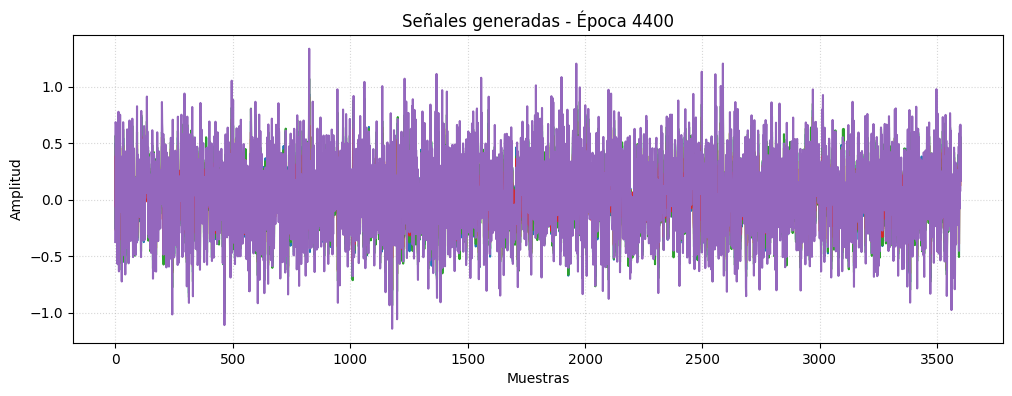

Epoch: 4450 | Loss_D: 0.0000 | Loss_G: 98.7906 | Time: 15:46:33
Epoch: 4500 | Loss_D: 0.0000 | Loss_G: 97.9446 | Time: 15:46:34
Epoch: 4500 | Loss_D: 0.0000 | Loss_G: 97.9446 | Time: 15:46:34


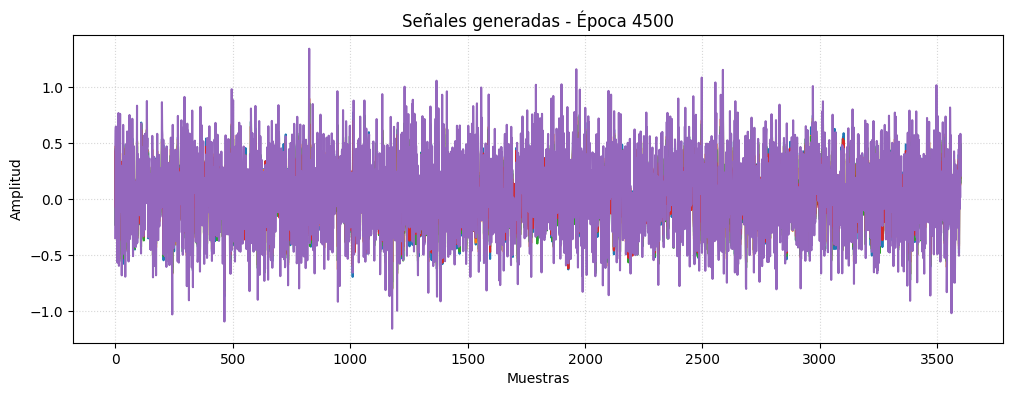

Epoch: 4550 | Loss_D: 0.0000 | Loss_G: 98.1081 | Time: 15:46:34
Epoch: 4600 | Loss_D: 0.0000 | Loss_G: 98.6825 | Time: 15:46:35
Epoch: 4600 | Loss_D: 0.0000 | Loss_G: 98.6825 | Time: 15:46:35


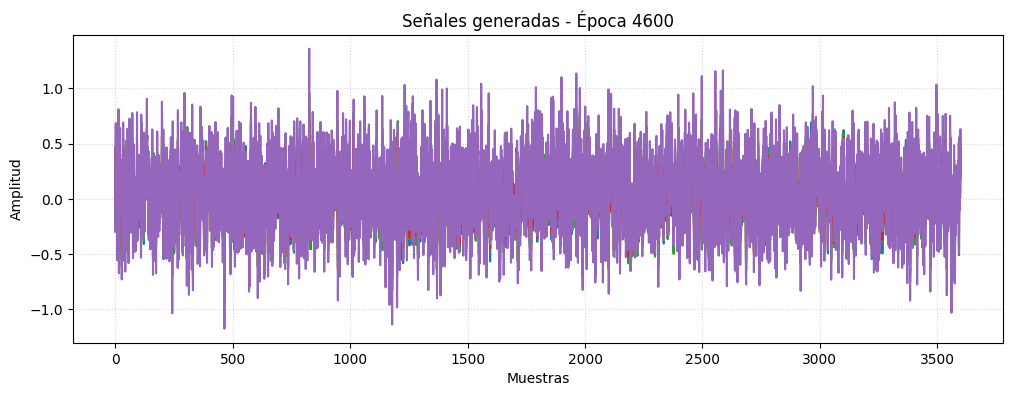

Epoch: 4650 | Loss_D: 0.0000 | Loss_G: 97.9471 | Time: 15:46:36
Epoch: 4700 | Loss_D: 0.0000 | Loss_G: 97.4840 | Time: 15:46:37
Epoch: 4700 | Loss_D: 0.0000 | Loss_G: 97.4840 | Time: 15:46:37


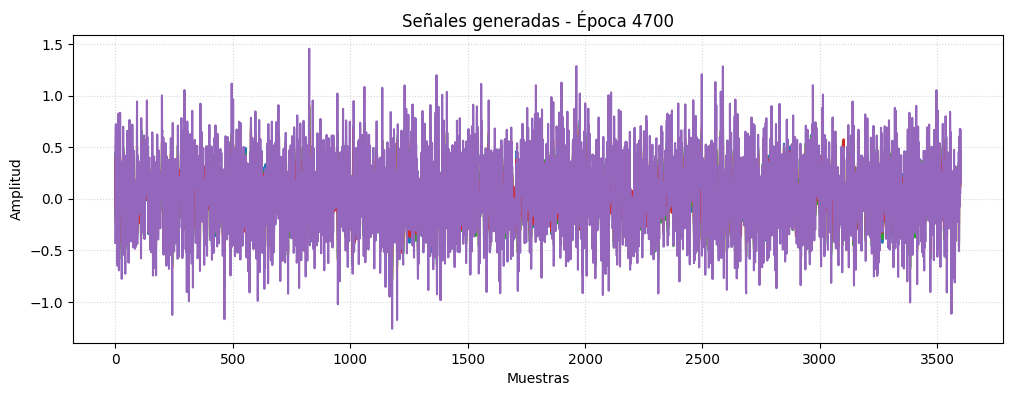

Epoch: 4750 | Loss_D: 0.0000 | Loss_G: 96.9595 | Time: 15:46:38
Epoch: 4800 | Loss_D: 0.0000 | Loss_G: 98.0596 | Time: 15:46:39
Epoch: 4800 | Loss_D: 0.0000 | Loss_G: 98.0596 | Time: 15:46:39


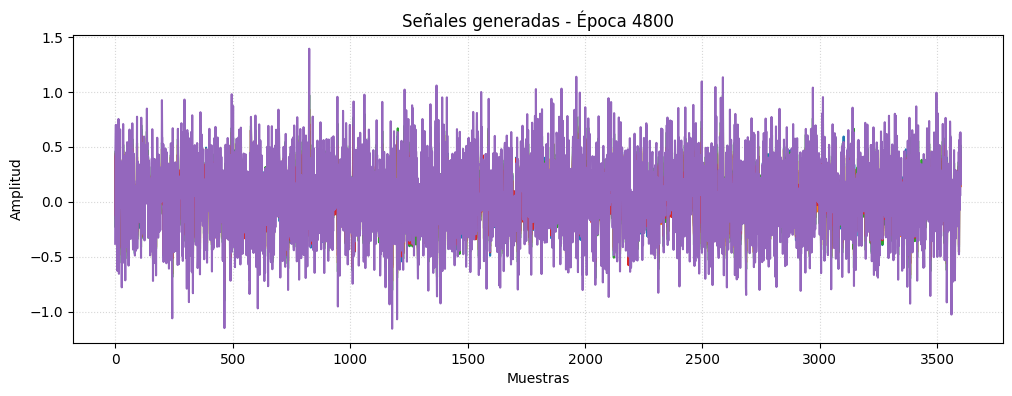

Epoch: 4850 | Loss_D: 0.0000 | Loss_G: 97.5662 | Time: 15:46:39
Epoch: 4900 | Loss_D: 0.0000 | Loss_G: 98.3094 | Time: 15:46:40
Epoch: 4900 | Loss_D: 0.0000 | Loss_G: 98.3094 | Time: 15:46:40


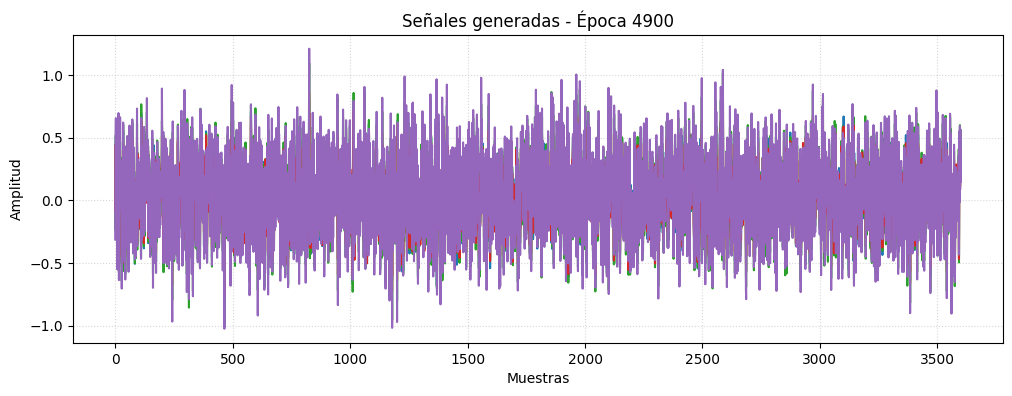

Epoch: 4950 | Loss_D: 0.0000 | Loss_G: 97.8583 | Time: 15:46:41
Modelos guardados exitosamente!
Modelos guardados exitosamente!


In [64]:
trainer = Trainer(
    generator=g,
    discriminator=d,
    batch_size=96,
    num_epochs=5000,
    label='NSR',
    signal_length=3600
)
trainer.run()